In [112]:
import numpy as np
from numpy.fft import fft2, fft, ifft, ifft2

# mistakes: 
# giving fft input 2d array
# arrange instead of arange
# shapes

In [4]:
N = 10
x = np.random.random(N).reshape((N//2, 2))
x

array([[0.93251127, 0.32513812],
       [0.48460909, 0.15467844],
       [0.81599527, 0.82355466],
       [0.87607245, 0.12978211],
       [0.9508346 , 0.44766614]])

### axis enumeration:
axis=0   is up/down, ei. change of rows

axis=1   is left/right, ei. change of cols

In [5]:
res2 = fft2(x)
print(res2)


[[ 5.94084215+0.j          2.17920322+0.j        ]
 [-0.2528166 +0.34957788j  0.26716904+0.60786069j]
 [ 0.426519  +1.04893442j  0.16166223-0.61512707j]
 [ 0.426519  -1.04893442j  0.16166223+0.61512707j]
 [-0.2528166 -0.34957788j  0.26716904-0.60786069j]]


In [6]:
def myfunc(x):
    return fft(x)

fft2 can be calculated by
first applying fft on each matrix row
then applying fft on that

In [7]:
# slower onEachRow = np.apply_along_axis(func1d=myfunc, axis=1, arr=x)
onEachRow = fft(x, axis=1)
#print(onEachRow)

# slower onEachCol = np.apply_along_axis(func1d=myfunc, axis=0, arr=onEachRow)
# np.apply_along_axis is slower because it uses python loops under the hood
onEachCol = fft(onEachRow, axis=0)
print(onEachCol)
print("good results? ", np.allclose(onEachCol, res2))

[[ 5.94084215+0.j          2.17920322+0.j        ]
 [-0.2528166 +0.34957788j  0.26716904+0.60786069j]
 [ 0.426519  +1.04893442j  0.16166223-0.61512707j]
 [ 0.426519  -1.04893442j  0.16166223+0.61512707j]
 [-0.2528166 -0.34957788j  0.26716904-0.60786069j]]
good results?  True


In [8]:
def myfft2(x):
    ''' Computes 2d fft using numpys fft '''
    onEachRow = fft(x, axis=1)
    return fft(onEachRow, axis=0)


In [97]:
t = np.arange(1000).reshape(10,100)
%timeit f2 = fft2(t)
print('myfft2 is faster than fft2, but only at sub 10k lens')
%timeit f1 = myfft2(t)
print(np.allclose(myfft2(t), fft2(t)))

54.6 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
myfft2 is faster than fft2, but only at sub 10k lens
38.7 µs ± 486 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
True


In [54]:
def myfft_bad(x):
    #x = x.astype(float)
    N = x.shape[0]
    n = np.arange(N).reshape((N,1))
    k = n.reshape((1,N))
    # k and n make an N x N matrix of 
    # complex coefficients that get multiplied with x
    Mat = np.exp(np.pi * k * n/ N * -2j)
    return np.dot(Mat, x)

In [11]:
t=np.arange(4000)

v1 = myfft_bad(t)
v2 = fft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [122]:
# at len(t)=3000 myff_bad takes 614ms, and at 4k it takes 1.1s
# while np.fft only takes 63µs 
%timeit myfft_bad(t)
%timeit fft(t)
print('myfft_bad is a lot slower than npfft')
print('myfft_bad has O(N^2) numerical operations while np.fft has O(NlogN)')

1.09 s ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
62.8 µs ± 222 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
myfft_bad is a lot slower than npfft
myfft_bad has O(N^2) numerical operations while np.fft has O(NlogN)


In [123]:
#testing types
test = np.array([1,2,3])
test2 = test.astype(float)
print(test.dtype)
print(test2.dtype)

a = test.reshape(3,1)
print(a.shape)
a = test.reshape((3,1))
print(a.shape)

arr = np.arange(10)
print(arr.shape)
arr = np.arange(10).reshape(10,1)
print(arr.shape)

n = np.arange(10)
k = n.reshape((10, 1))
#print(n*k)
n = np.arange(10).reshape((10,1))
k = n.T
#print(n*k)
#print(n*n.T)

int32
float64
(3, 1)
(3, 1)
(10,)
(10, 1)


In [55]:
def myfft_better(x):
    ''' Cooley Turkey FFT, only works for lenghts that are power of 2 '''
    #x = x.astype(float)
    N = x.shape[0]
    
    if N % 2 != 0:
        raise Exception("Error, len(x) has to be power of 2")
    if N <= 8: # at some point it's better to fall back to the basic algorithm
        return myfft_bad(x)
    even = myfft_better(x[::2])
    odd = myfft_better(x[1::2])
    multiplier = np.exp( np.pi * np.arange(N) / N * -2j)
    return np.concatenate([even + multiplier[:N//2] * odd, 
        even + multiplier[N//2:] * odd])


In [56]:
t=np.arange(4096)

v1 = myfft_better(t)
v2 = fft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [43]:
%timeit myfft_bad(t)
%timeit myfft_better(t)
%timeit fft(t)
print("myfft is still slower, but orders of magnitute faster than the other implementation")
print("len(t)=4096")
print("N=64 -> 17ms, N=32 -> 10ms, N=16 -> 9.5ms, N=8 -> 12.2ms")

1.13 s ± 7.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.5 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
myfft is still slower, but orders of magnitute faster than the other implementation
N=64 -> 17ms, N=32 -> 10ms, N=16 -> 9.5ms, N=8 -> 12.2ms


In [57]:
def my2dfft(x):
    onEachRow = np.apply_along_axis(myfft_better, 1, x)
    return np.apply_along_axis(myfft_better, 0, onEachRow)

In [60]:
t=np.arange(4096).reshape(512,8)

v1 = fft2(t)
v2 = my2dfft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [63]:
s = 256
t=np.arange(s*s).reshape(s,s)
%timeit myfft2(t)
%timeit my2dfft(t)
%timeit fft2(t)

print('a lot slower than the fortrans fft2 implementation, but useable')
print('N=512x512 -> my2dfft 1s')

2.4 ms ± 72.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
328 ms ± 8.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.33 ms ± 40 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a lot slower than the fortrans fft2 implementation, but useable


array([[1],
       [2],
       [3],
       [4],
       [5]])

In [94]:
print('''Problem with the last implementation of 2dfft is that on each node in the
recursive tree the same vector is constructed and multiplied with given input,
it would be a lot faster if it could be vectorized. And it can be!''')
def my2dfft_better(x):
    ''' vectorized Cooley Turkey, not recursive'''
    N = x.shape[0]
    
    # hacky way of checking if a number is power of two
    # faster than log checking and not error prone
    if not ( ((N & (N - 1)) == 0) and N > 0 ):
        raise Exception("Error, len(x) has to be power of 2")
    
    # chungs of input onto which to apply the same multiplication
    sliceSize = min(N, 32)
    
    #One shape dimension can be -1. In this case, 
    #the value is inferred from the length of the array and remaining dimensions.
    xslices = x.reshape(sliceSize, -1)
    
    # applying calculation of myfft_bad on all slices
    n = np.arange(sliceSize)
    # in numpy None at index creates an axis with length 1.
    k = n[:, np.newaxis]
    factors = np.exp(np.pi * k * n/N * -2j)
    X = np.dot(factors, xslices)
    
    while N > x.shape[0]:
        #analogous to even/odd in myfft_better
        firstHalf = X[:, :x.shape[1]//2]
        secondHalf = X[:,  x.shape[1]//2:]
        N = np.arange(X.shape[0])
        factor = np.exp(np.pi * N / X.shape[0] * -1j)[:, np.newaxis]
        X = np.vstack([
            firstHalf + factor * secondHalf,
            firstHalf - factor * secondHalf
        ])
    
    # like flatten but it only makes a copy if it's needed
    return X.ravel()

Problem with the last implementation of 2dfft is that on each node in the
recursive tree the same vector is constructed and multiplied with given input,
it would be a lot faster if it could be vectorized. And it can be!


In [93]:
s = 256
t=np.arange(s*s).reshape(s,s)
%timeit my2dfft_better(t)
%timeit my2dfft(t)
%timeit fft2(t)


1.18 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
316 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.22 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [147]:
# https://www.dsprelated.com/showarticle/800.php
def myifft(x):
    #method#3, for some reason it doesn't work
#     real = x.real
#     x.real = x.imag
#     x.imag = real
#     y = myfft_better(x)
#     real = y.real
#     y.real = y.imag
#     y.imag = real
#     return y / y.shape[0]
    # method#4, works well
    x.imag *= -1
    y = myfft_better(x)
    y.imag *= -1
    return y / y.shape[0]

In [145]:
x = np.arange(16)
f = fft(x)
print(np.allclose(ifft(f), myifft(f)))
print(ifft(f))
print(myifft(f))

True
[ 0.+0.00000000e+00j 15.+1.13242749e-14j 14.+9.42545333e-15j
 13.+1.03250741e-14j 12.+2.22044605e-16j 11.+3.33066907e-15j
 10.+3.00904454e-15j  9.+3.88578059e-15j  8.+0.00000000e+00j
  7.-4.66293670e-15j  6.-3.00904454e-15j  5.-4.32986980e-15j
  4.-2.22044605e-16j  3.-9.99200722e-15j  2.-9.42545333e-15j
  1.-9.88098492e-15j]
[ 0.+6.66133815e-16j 15.+7.94738930e-15j 14.+3.43999064e-15j
 13.+4.36876431e-15j 12.-2.26621556e-15j 11.-1.02576502e-16j
 10.+1.86519211e-15j  9.-1.44558843e-15j  8.-7.11903325e-16j
  7.-3.37688556e-15j  6.-1.00090146e-15j  5.+8.16050634e-16j
  4.+1.82212635e-15j  3.-6.09778084e-15j  2.-7.01659209e-15j
  1.+1.09889094e-14j]


In [150]:
def myifft2(x):
    onEachRow = np.apply_along_axis(myifft, 1, x)
    onEachCol =  np.apply_along_axis(myifft, 0, onEachRow)
    return onEachCol #.real

In [151]:
x = np.arange(16).reshape(4,4)
f = fft2(x)
print(np.allclose(ifft2(f), myifft2(f)))
print(ifft2(f))
print(myifft2(f))

True
[[ 0.+0.j  3.+0.j  2.+0.j  1.+0.j]
 [12.+0.j 15.+0.j 14.+0.j 13.+0.j]
 [ 8.+0.j 11.+0.j 10.+0.j  9.+0.j]
 [ 4.+0.j  7.+0.j  6.+0.j  5.+0.j]]
[[ 0.-0.00000000e+00j  3.-1.83697020e-16j  2.-1.22464680e-16j
   1.+1.83697020e-16j]
 [12.-7.34788079e-16j 15.-9.18485099e-16j 14.-8.57252759e-16j
  13.-5.51091060e-16j]
 [ 8.-4.89858720e-16j 11.-6.73555740e-16j 10.-6.12323400e-16j
   9.-3.06161700e-16j]
 [ 4.+7.34788079e-16j  7.+5.51091060e-16j  6.+6.12323400e-16j
   5.+9.18485099e-16j]]


In [100]:
# program implementation
import numpy
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import misc
from scipy import ndimage
import math
import matplotlib.pyplot as plt

def makeGaussianFilter(numRows, numCols, sigma, highPass=True):
    centerI = int(numRows/2) + 1 if numRows % 2 == 1 else int(numRows/2)
    centerJ = int(numCols/2) + 1 if numCols % 2 == 1 else int(numCols/2)

    def gaussian(i,j):
        coefficient = math.exp(-1.0 * ((i - centerI)**2 + (j - centerJ)**2) / (2 * sigma**2))
        return 1 - coefficient if highPass else coefficient
    
    return numpy.array([[gaussian(i,j) for j in range(numCols)] for i in range(numRows)])
 
def filterDFT(imageMatrix, filterMatrix):
    shiftedDFT = fftshift(fft2(imageMatrix))

    filteredDFT = shiftedDFT * filterMatrix

    #plt.imshow(filteredDFT.real, cmap='gray')
    #plt.show()

    res = ifft2(ifftshift(filteredDFT))

    return res
 
def lowPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=False))
 
def highPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=True))

def hybridImage(highFreqImg, lowFreqImg, sigmaHigh, sigmaLow):
    highPassed = highPass(highFreqImg, sigmaHigh)
    lowPassed = lowPass(lowFreqImg, sigmaLow)
    return highPassed/2 + lowPassed/4

def showImg(img):
    plt.imshow(img, cmap='gray')
    plt.show()

c:\users\dzoni\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.
c:\users\dzoni\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


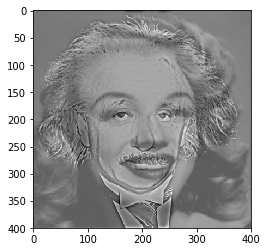

In [109]:
marilyn = ndimage.imread("marilyn.png", flatten=True)
einstein = ndimage.imread("albert.png", flatten=True)

hybrid = hybridImage(einstein, marilyn, 20, 55)
showImg(hybrid.real)